# PyData Amsterdam 2019 :: Numba Tutorial Notebook 3 :: Memory Management

## Managing GPU Memory

During the benchmarking in the previous notebook, we used NumPy arrays on the CPU as inputs and outputs.  If you want to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls.  In addition, allocating device memory can be relatively slow, so allocating GPU arrays once and refilling them with data from the host can also be a performance improvement.

Let's create our example addition ufunc again:

In [0]:
from numba import vectorize
import numpy as np

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [0]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [20]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

The slowest run took 69.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.05 ms per loop


There are two ways that we can create GPU arrays to pass to Numba.  Numba defines its own GPU array object (not as fully-featured as CuPy, but may be useful if you don't need the rest of CuPy for your application).  The `numba.cuda` module includes a function that will copy host data to the GPU and return a CUDA device array:

In [21]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to Numba's compiled CUDA functions just like NumPy arrays, but without the copy overhead:

In [22]:
%timeit add_ufunc(x_device, y_device)

1000 loops, best of 3: 1.67 ms per loop


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host.  We can create the output buffer with the `numba.cuda.device_array()` function:

In [0]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special `out` keyword argument to the ufunc to specify the output buffer:

In [24]:
%timeit add_ufunc(x_device, y_device, out=out_device)

1000 loops, best of 3: 1.83 ms per loop


Now that we have removed the device allocation and copy steps, the computation runs *much* faster than before.  When we want to bring the device array back to the host memory, we can use the `copy_to_host()` method:

In [25]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


## CuPy Interoperability

Recent versions of CuPy (>= 4.5) support (Numba's generic CUDA array interface)[https://numba.pydata.org/numba-doc/latest/cuda/cuda_array_interface.html].  We can see this on a CuPy array, by looking for the `__cuda_array_interface__` attribute:

In [26]:
import cupy as cp

x_cp = cp.asarray(x)
y_cp = cp.asarray(y)
out_cp = cp.empty_like(y_cp)

x_cp.__cuda_array_interface__

{'data': (30126382080, False),
 'descr': [('', '<f4')],
 'shape': (100000,),
 'typestr': '<f4',
 'version': 0}

This describes the CuPy array in a portable way so that other packages, like Numba, can use it:

In [27]:
add_ufunc(x_cp, y_cp, out=out_cp)

print(out_cp[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


And it runs the same speed as using the Numba device allocation:

In [28]:
%timeit add_ufunc(x_cp, y_cp, out=out_cp)

1000 loops, best of 3: 922 µs per loop


Note that Numba won't automatically create a CuPy array for the ufunc output, so if you want to ensure the ufunc result is saved in a CuPy array, be sure to pass an explicit `out` argument to the ufunc, as shown above.

# Exercise

Given these ufuncs:

In [0]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Convert this code to use device allocations so that there are only host<->device copies at the beginning and end and benchmark performance change.  Use either CuPy arrays or Numba device allocations.

In [0]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

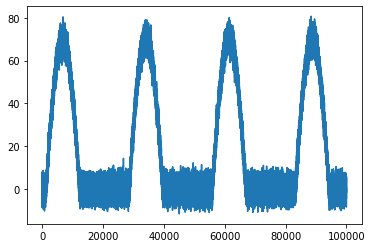

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

In [0]:
pulses_cp = cp.asarray(pulses)
noise_cp = cp.asarray(noise)
waveform_cp = cp.empty_like(pulses_cp)

In [33]:
%timeit add_ufunc(pulses, noise)

100 loops, best of 3: 2.15 ms per loop


In [35]:
%timeit add_ufunc(pulses_cp,noise_cp,out=waveform_cp)

The slowest run took 5.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 924 µs per loop
